In [1]:
import torch
import numpy as np
from scipy.io.wavfile import read, write
from scipy import signal
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import seaborn as sns


from Model import Net
from boltzman_machine import RBM
from Dataloader import AudioDataset
from helpers import Reconstruct, Viz_Y


from torch.optim import LBFGS, Adam,SGD
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import warnings 

import tqdm
from helpers2 import *
warnings.simplefilter('ignore')

In [2]:
def gain_params(s1,s2,y):

        l2_s1 = torch.norm(s1.float(),2, None)
                 
        l2_s2 = torch.norm(s2.float(),2, None)
               
        l2_Y = torch.norm(y.float(),2, None)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
def gain_params_vec(s1,s2,y):

        l2_s1 = torch.norm(s1.float().t(),2, True)
                 
        l2_s2 = torch.norm(s2.float().t(),2, True)
               
        l2_Y = torch.norm(y.float().t(),2, True)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
    
def feed_(x):
    
    f = model(x)
    f1 = f[0] 
    f2 = f[1]
    return f1,f2

def energy_1(x_source1):
    
    f1,f2 = feed_(x_source1)
    e1 = (1 - f1 ).pow(2) + f2.pow(2)
    return e1 

def energy_2(x_source2):

    f1,f2 = feed_(x_source2)
    e2 = f1.pow(2) + (1 - f2 ).pow(2) 
    return e2

def E_err(s1,s2,y):
  
    u,v = gain_params_vec(s1,s2,y) 
    return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

def E_err_vec(s1,s2,y,u,v):
  
    return torch.norm(u*s1 + v*s2 - y,'fro',None)


def relu(x):
    return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y,u,v):  
    
    u_sum  = torch.sum(relu(u))
    v_sum  = torch.sum(relu(v))
    x1_sum = torch.sum(relu(s1))
    x2_sum = torch.sum(relu(s2))
    total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

    return total_sum 


def nonneg_constraint(s1,s2,u,v):
    
    R=min([s1.min().item(),s2.min().item(),u,v,0])
    
    return R**2


def nonneg_constraint_sum(s1,s2,u,v):
    
    Rs1=min([s1.min().item(),0])**2
    Rs2=min([s2.min().item(),0])**2
    Ru=min([u,0])**2
    Rv=min([v,0])**2
    
    return Rs1+Rs2+Ru+Rv

# 1.Read audio file:

In [14]:
samplerate_s, data_speech = read("../../DATA/vocal_11.wav")
samplerate_m, data_music = read("../../DATA/piano_10.wav")

rate = samplerate_s / 16000


fs = 16000


start = 580 * 44100
end = 585 * 44100

start = 3 * 60 * 44100
end = 4 * 60 * 44100 

speech_t=data_speech[start : end,0]
music_t = data_music[start:end, 0]


speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music_t = signal.resample(music_t,int(music_t.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate

print('Shape of the test {} ... Length : {:.2f}s ... Sample rate : {}'.format(music_t.shape[0],length,samplerate))
print('Downsampled rate = {}'.format(samplerate))


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


music_t = butter_lowpass_filter(music_t,4000,fs)
speech_t = butter_lowpass_filter(speech_t,4000,fs)

Shape of the test 960000 ... Length : 60.00s ... Sample rate : 16000
Downsampled rate = 16000


In [15]:
SMR_db = 0
test,speech_test,music_test=get_mixed_signal(speech_t,music_t,SMR_db)

WINDOW = 'barthann'
WINDOW_SIZE=480
OVERLAP = 0.8 * WINDOW_SIZE
NFFT=512

f,t,Y= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_t=np.abs(Y)

Yabs_t[Yabs_t==0]=0.00001


SMR = 0.00


In [16]:
B = np.load('../NMF/B.npy')
Ns = 10
Nm = 10
p = 3


model_test = NMF(n_components=Ns+Nm, init='nndsvd',alpha=0.2,beta_loss='itakura-saito',solver="mu",max_iter=200, random_state=7)
model_test.fit(np.transpose(Yabs_t))

model_test.components_=B
G_test=model_test.transform(np.transpose(Yabs_t))

print('Testing NMF .... Done')
Sources,Masks=Reconstruct(B=np.transpose(B),G=np.transpose(G_test),Ns=Ns,Nm=Nm,Yabs=Y,p=p)

print('Reconstruction Step .... Done')
speech_est = Sources[0]
music_est = Sources[1]

_, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

_, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

speech_est = speech_est[:speech_test.shape[0]]
music_est = music_est[:music_test.shape[0]]

sdr_speech = SDR(s_est=speech_est,s=speech_test)
sdr_music = SDR(s_est=music_est, s=music_test)

print('SDR Speech = {:.2f} ... SDR Music = {:.2f}'.format(sdr_speech,sdr_music))

write("../../Tests/SpeechX.wav", samplerate, speech_est.astype(np.int16))
write("../../Tests/MusicX.wav", samplerate, music_est.astype(np.int16))


Testing NMF .... Done
Reconstruction Step .... Done
SDR Speech = 2.72 ... SDR Music = 2.72


 # Learning Loop :

* Define optimizer with all parameters W , x1 , x2 , u , v
* Dataloader gives a batch that we loop accross
* For each sample we feed the network with X1 and then we get f1 
* We feed with X2 and we get f2
* We compute u and v using the function.
* We compute the total loss.
* Loss.back()
* Optimizer step 

# 5.Train the DNN :

## 5.1.Compute the initial  estimates of u and v : y = u * s1 + v * s2

In [6]:
Yabs = Yabs_t
s1 = abs(Sources[0])
s2 = abs(Sources[1])
Yabs = torch.tensor(Yabs)

scaler_s1 = MinMaxScaler()
scaler_s2 = MinMaxScaler()
scaler_y = MinMaxScaler()

s1 = scaler_s1.fit_transform(s1)
s2 = scaler_s2.fit_transform(s2)
Yabs = scaler_y.fit_transform(Yabs)

s1 = torch.tensor(s1)
s2 = torch.tensor(s2)
Yabs = torch.tensor(Yabs)
u,v = gain_params_vec(s1, s2, Yabs)

u0 = u ; v0 = v

u00 = u0.detach().numpy()
v00 = v0.detach().numpy()

In [7]:
print('The number of Max = {}'.format(scaler_y.data_max_.shape[0]))

The number of Max = 20001


### Visualize initial distribution :

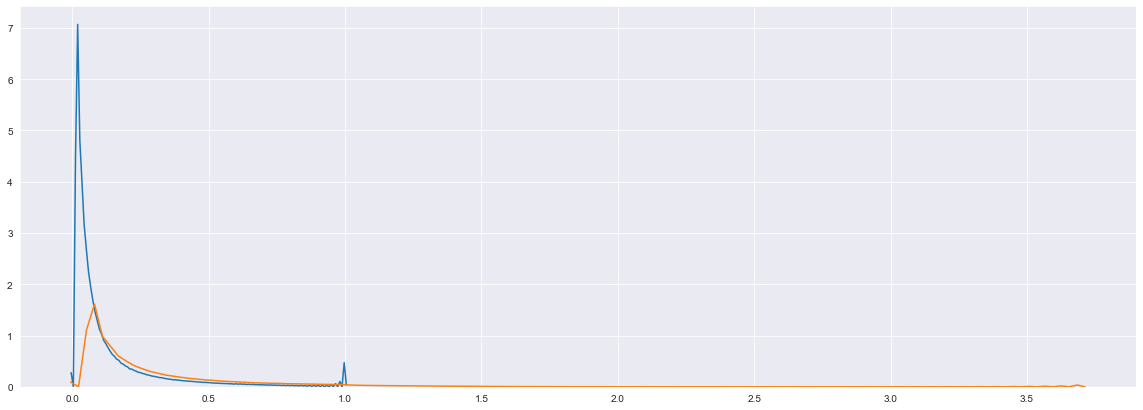

In [8]:
sns.set_style('darkgrid')
fig,ax=plt.subplots(1,1,figsize=(20,7))
sns.distplot(Yabs.detach().numpy(),hist=False,ax=ax)
sns.distplot((u0*s1+v0*s2).detach().numpy(), hist = False,ax=ax)

## 5.2.Set the require grads to true:


In [9]:
s1.requires_grad = True
s2.requires_grad = True
u.requires_grad = True
v.requires_grad = True
Yabs.requires_grad = False

## 5.3.Instantiation of the model with pretrained wheights of RBM:

In [10]:
model = Net(257)

model_1 = RBM(257,100)
model_1.load_state_dict(torch.load("../RBM/pretraining/w_layer_1"))
model_2 = RBM(100,50)
model_2.load_state_dict(torch.load("../RBM/pretraining/w_layer_2"))
model_3 = RBM(50,200)
model_3.load_state_dict(torch.load("../RBM/pretraining/w_layer_3"))


with torch.no_grad():
    model.fc1.weight = model_1.feed.weight
    model.fc2.weight = model_2.feed.weight
    model.fc3.weight = model_3.feed.weight
print(model)


Net(
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=257, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=2, bias=True)
)


## 5.4. Define loss function :

$$E_{1}(\boldsymbol{x})=\left(1-f_{1}(\boldsymbol{x})\right)^{2}+\left(f_{2}(\boldsymbol{x})\right)^{2}$$ \\
$$E_{2}(\boldsymbol{x})=\left(f_{1}(\boldsymbol{x})\right)^{2}+\left(1-f_{2}(\boldsymbol{x})\right)^{2}$$


$$E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)=\left\|u \boldsymbol{x}_{1}+v \boldsymbol{x}_{2}-\boldsymbol{y}\right\|^{2}$$

Let's consider $\boldsymbol{\theta}=\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, u, v\right)=\left[\theta_{1}, \theta_{2}, \ldots, \theta_{n}\right]$  a vector containing all the unknowns which must all be nonnegative.

$$R(\theta)=(\min (\theta, 0))^{2}$$

$$\begin{aligned} E\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right) &=E_{1}\left(\boldsymbol{x}_{1}\right)+E_{2}\left(\boldsymbol{x}_{2}\right)+\lambda E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)  + \beta \sum_{i} R\left(\theta_{i}\right) \end{aligned}$$

In [11]:
def Criteria(s1,s2,Yabs,u,v,i,lambd,beta) :
    
    # Feed forward and get energy 1 and 2
    e1 = energy_1(s1[:,i].float())
    e2 = energy_2(s2[:,i].float())
    
    # Get least square error :
    e_rr=E_err_vec(s1[:,i], s2[:,i], Yabs[:,i],u[i],v[i])
    
    # Non negative constraint
    R = nonneg_constraint_sum(s1[:,i], s2[:,i], u[i], v[i])
    
    # Compute total Loss :
    
    #print(f'E1 = {e1:.2f} ... E2 = {e2:.2f} ... Err = {e_rr:.2f} ... R = {R:.2f} \n')
    
    return e1 + e2 + lambd*e_rr + beta*R
    

## 5.5 LBFGS code (slow):

params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= LBFGS(params, lr=0.1, max_iter=20, tolerance_grad=1e-07)
model.train()
for i in range(s1.shape[1]):
    
    def closure():
        optimizer.zero_grad()
        loss = Criteria(s1,s2,Yabs,u,v,i)
        loss.backward()
        return loss
        
        
    print('step i= {}'.format(i))
    optimizer.step(closure)

## 5.6. Define optimizer and the parameters to optimize : s1 s2 u v and network parameters:

In [12]:
params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= SGD(params, lr=0.001)

## 5.7.Train the model:

In [13]:
model.train()
N_epochs = 10
for e in range(N_epochs):
    
    loss_e=0.0
    for i in tqdm.tqdm(range(s1.shape[1]),leave=True,position=0):

            optimizer.zero_grad()
            loss = Criteria(s1,s2,Yabs,u,v,i,1,1)
            loss.backward()
            # fill zeros into the first row of grad
            u.grad.data[:i].fill_(0)
            u.grad.data[i+1:].fill_(0)
            
            v.grad.data[:i].fill_(0)
            v.grad.data[i+1:].fill_(0)
            s1.grad.data[:,:i].fill_(0)
            s1.grad.data[:,i+1:].fill_(0)
            s2.grad.data[:,:i].fill_(0)
            s2.grad.data[:,i+1:].fill_(0)



            optimizer.step()
            loss_e+=loss
            
    print('Epoch {} , Loss = {:.2f}'.format(e,loss_e/s1.shape[1]))

 10%|███████▍                                                                   | 1976/20001 [10:17<1:32:31,  3.25it/s]

KeyboardInterrupt: 

In [20]:
PATH='model_dict2.pt'
torch.save(model.state_dict(), PATH)
np.save('s11',s1.detach().numpy())
np.save('s22',s2.detach().numpy())
np.save('u2',u.detach().numpy())
np.save('v2',v.detach().numpy())

# 6.Check the results:

## 6.1.Check that all values are positive:

In [23]:
print('Min of s1 {:.4f}'.format(s1.min()))
print('Min of s2 {:.4f}'.format(s2.min()))
print('Min of U {:.4f}'.format(u.min()))
print('Min of V {:.4f}'.format(v.min()))

Min of s1 -0.1732
Min of s2 -0.2325
Min of U 0.3339
Min of V 0.2209


## 6.2.Check the distribution :

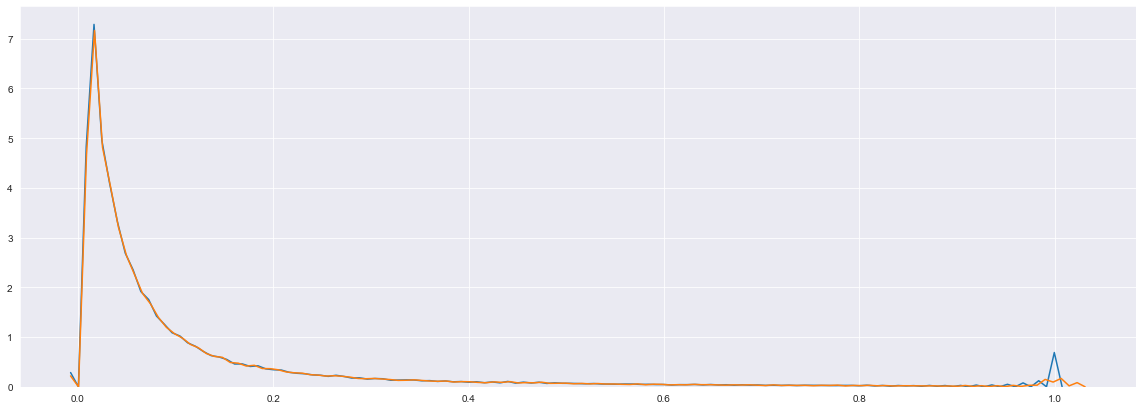

In [24]:
plt.figure(figsize=(20,7))
sns.distplot(Yabs.detach().numpy(),hist=False)
sns.distplot((u*s1+v*s2).detach().numpy(), hist = False)

## 6.3. Check the L2 loss:

In [25]:
print('L2 loss = {}'.format(torch.norm(torch.tensor(u00)*s1 + torch.tensor(v00)*s2 - Yabs,'fro',None)))

L2 loss = 0.7161318835282391


In [26]:
print('L2 loss = {}'.format(torch.norm(u*s1 + v*s2 - Yabs,'fro',None)))

L2 loss = 0.7161318835282391


# Load Model:

In [ ]:
model = Net(d=257)
model.load_state_dict(torch.load(PATH))

# Evaluate Model:

In [27]:
def reconstruct(est1,est2,u,v,Y,p):
    
    speech_num = (u * est1)**p
    music_num = (v * est2)**p
    den = (u * est1)**p + (v * est2)**p
    
    speech_est = (speech_num/den)*Y
    music_est = (music_num/den)*Y
    
    return speech_est,music_est
    

In [33]:
# In absolute values :


speech_est = np.load('s11.npy')
music_est = np.load('s22.npy')

u = np.load('u2.npy')
v= np.load('v2.npy')
speech_est = scaler_s1.inverse_transform(speech_est)
music_est = scaler_s2.inverse_transform(music_est)


# Omit negative values
speech_est[speech_est<0]=0.00001
music_est[music_est<0]=0.00001

speech_est_c,music_est_c=reconstruct(speech_est,music_est,u,v,Y,1)



#Recover ISTFT
_, speech_est_sig =  signal.istft(speech_est_c,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

_, music_est_sig =  signal.istft(music_est_c,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)


speech_est_sig = speech_est_sig[:speech_test.shape[0]]
music_est_sig = music_est_sig[:music_test.shape[0]]

sdr_speech = SDR(s_est=speech_est_sig,s=speech_test)
sdr_music = SDR(s_est=music_est_sig, s=music_test)
    
print('SDR Speech = {:.2f} ... SDR Music = {:.2f}'.format(sdr_speech,sdr_music))

write("../../Tests/SpeechDNN.wav", samplerate, speech_est_sig.astype(np.int16))
write("../../Tests/MusicDNN.wav", samplerate, music_est_sig.astype(np.int16))

SDR Speech = 2.40 ... SDR Music = 2.40
